# Use Roboflow with Chroma

With [Roboflow Inference](https://inference.roboflow.com), you can calculate image embeddings using CLIP, a popular multimodal embedding model. You can then store these embeddings in Chroma for use in your application.

In this guide, we are going to discuss how to load image embeddings into Chroma. We will discuss:

1. How to set up Roboflow Inference
2. How to create a Chroma vector database
3. How to calculate CLIP embeddings with Inference
4. How to run a search query with Chroma

## What is Roboflow Inference?

[Roboflow Inference](https://inference.roboflow.com) is a scalable server through which you can run fine-tuned object detection, segmentation, and classification models, as well as popular foundation models such as CLIP.

Inference handles all of the complexity associated with running vision models, from managing dependencies to maintaining your environment.

Inference is trusted by enterprises around the world to manage vision models, with the hosted version powering millions of API calls each month.

Inference runs in Docker and provides a HTTP interface through which to retrieve predictions.

We will use Inference to calculate CLIP embeddings for our application.

There are two ways to use Inference:

1. On your device
2. Through the Inference API hosted by Roboflow

In this guide, we will use the hosted Inference API.

### Step #1: Create a Chroma Vector Database

To load and save image embeddings into Chroma, we first need images to embed. In this guide, we are going to use the COCO 128 dataset, a collection of 128 images from the Microsoft COCO dataset. This dataset is available on Roboflow Universe, a community that has shared more than 250,000 public computer vision datasets.

To download the dataset, visit the COCO 128 web page, click “Download Dataset” and click "show download code" to get a download code:

![COCO 128 dataset](https://media.roboflow.com/coco128.png)

Here is the download code for the COCO 128 dataset:

In [2]:
!pip install roboflow -q

API_KEY = ""

from roboflow import Roboflow

rf = Roboflow(api_key=API_KEY)
project = rf.workspace("team-roboflow").project("coco-128")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to COCO-128-2 in yolov8:: 100%|██████████| 768/768 [00:00<00:00, 3152.96it/s]



Above, replace the value associated with the `API_KEY` variable with your Roboflow API key. [Learn how to retrieve your Robflow API key](https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key).

Now that we have a dataset ready, we can create a vector database and start loading embeddings.

Install the Chroma Python client and supervision, which we will use to open images in this notebook, with the following command:

In [ ]:
!pip install chromadb supervision -q

Then, run the code below to calculate CLIP vectors for images in your dataset:

In [ ]:
import chromadb
import os
from chromadb.utils.embedding_functions import RoboflowEmbeddingFunction
import uuid
import cv2
import supervision as sv

client = chromadb.PersistentClient(path="database")

collection = client.create_collection(name="images_db", metadata={"hnsw:space": "cosine"})

In [30]:
IMAGE_DIR = dataset.location + "/train/images"
SERVER_URL = "https://infer.roboflow.com"

ef = RoboflowEmbeddingFunction(API_KEY, api_url = SERVER_URL)

documents = [os.path.join(IMAGE_DIR, img) for img in os.listdir(IMAGE_DIR)]
embeddings = ef([cv2.imread(doc) for doc in documents])
ids = [str(uuid.uuid4()) for _ in range(len(documents))]

collection.add(
    embeddings=embeddings,
    documents=documents,
    ids=ids,
)

['/content/COCO-128-2/train/images/000000000196_jpg.rf.8e48b2a4a9bd63fcd02ad61708d18ef2.jpg', '/content/COCO-128-2/train/images/000000000560_jpg.rf.26e523d9666e9eadffd6df0f9c6754f0.jpg', '/content/COCO-128-2/train/images/000000000384_jpg.rf.616518e6584f3a3b798d270382dd2b16.jpg', '/content/COCO-128-2/train/images/000000000626_jpg.rf.b776e538820040987b54f49d4a2bb7fb.jpg', '/content/COCO-128-2/train/images/000000000142_jpg.rf.5d34f341f09bef6870b506337bb426ad.jpg', '/content/COCO-128-2/train/images/000000000138_jpg.rf.af439ef1c55dd8a4e4b142d186b9c957.jpg', '/content/COCO-128-2/train/images/000000000094_jpg.rf.df1e8da2f564e0dc1f3e6401c05a1481.jpg', '/content/COCO-128-2/train/images/000000000387_jpg.rf.f6d68f4e3c90d097157a7d8fe1839b34.jpg', '/content/COCO-128-2/train/images/000000000086_jpg.rf.556402c74eccf93483195dc2000ceeb2.jpg', '/content/COCO-128-2/train/images/000000000486_jpg.rf.407a3acfe23dbf206d95b58a5d0aea37.jpg', '/content/COCO-128-2/train/images/000000000078_jpg.rf.afbc984af561c84

If you have downloaded custom images from a source other than the Roboflow snippet earlier in this notebook, replace `IMAGE_DIR` with the folder where your images are stored.

In this code snippet, we create a new Chroma database called `images`. Our database will use cosine similarity for embedding comparisons.

We calculate CLIP embeddings for all images in the `COCO128/train/images` folder using Inference. We save the embeddings in Chroma using the `collection.add()` method.

We store the file names associated with each image in the `documents` variable, and embeddings in `embeddings`.

If you want to use the hosted version of Roboflow Inference to calculate embeddings, replace the `SERVER_URL` value with `https://infer.roboflow.com`. We use the RoboflowEmbeddingFunction, built in to Chroma, to interact with Inference.

Run the script above to calculate embeddings for a folder of images and save them in your database.

We now have a vector database that contains some embeddings. Great! Let’s move on to the fun part: running a search query on our database.

### Step #3: Run a Search Query

To run a search query, we need a text embedding of a query. For example, if we want to find vegetables in our collection of 128 images from the COCO dataset, we need to have a text embedding for the search phrase “baseball”.

To calculate a text embedding, we can use Inference through the embedding function we defined earlier:

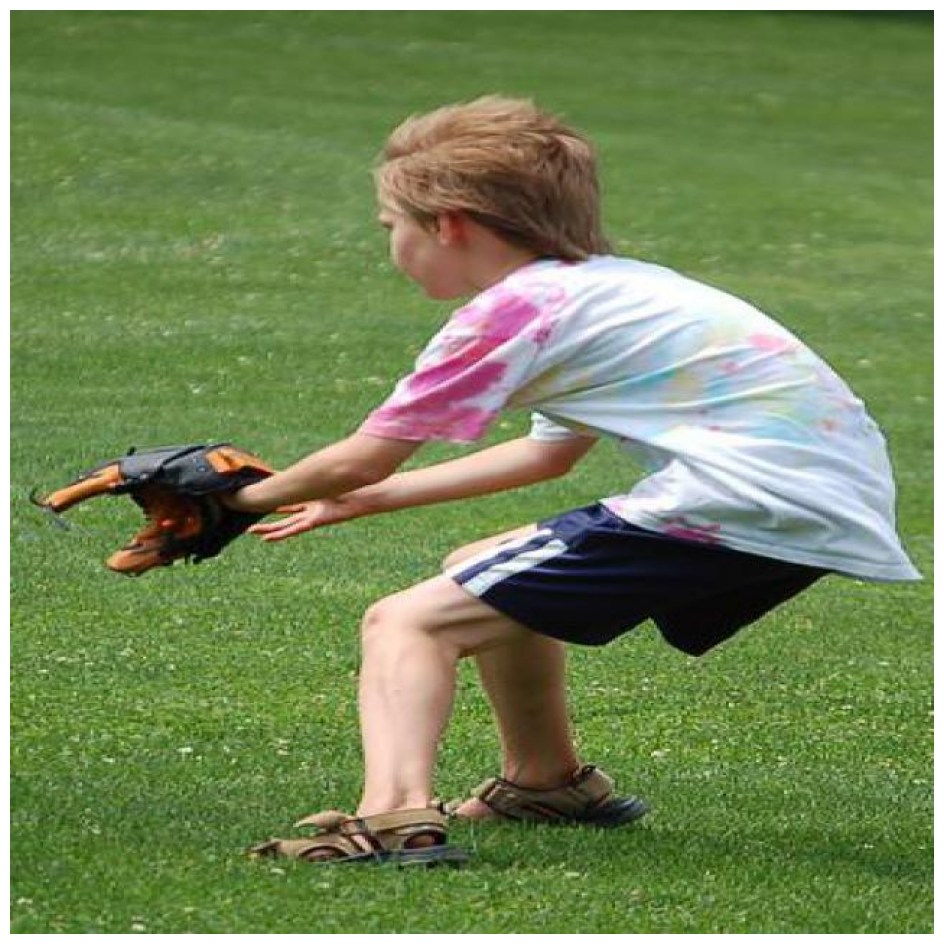

In [35]:
query = ef("baseball")

results = collection.query(
    query_embeddings=query,
    n_results=3
)

top_result = results["documents"][0][0]

sv.plot_image(cv2.imread(top_result))

Our code returns the name of the image with the most similar embedding to the embedding of our text query.

The top result is an image of a child holding a baseball glove in a park. Chroma successfully returned an image that matched our prompt.